# Neural Representation Method for Boltzmann Equation

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/physics_driven/mindspore_boltzmann.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/physics_driven/mindspore_boltzmann.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/physics_driven/boltzmann.ipynb)

## Problem Description

This case demonstrates how to solve the Boltzmann equation in 1+3 dimensions using neural networks. The Boltzmann equation is an equation for the gas density distribution function $f$, defined as

$$
\newcommand{\bm}[1]{\boldsymbol{#1}}
\begin{equation}
\label{eq:Boltzmann}
\frac{\partial f(\bm x,\bm v,t)}{\partial t}+\bm{v} \cdot\nabla_{\bm x} f(\bm x,\bm v,t)=\mathcal{Q}[f](\bm x, \bm v,t), \qquad  t \in \mathbb{R}^+, \quad \bm x \in  \mathbb{R}^3, \quad \bm v \in  \mathbb{R}^3,
\end{equation}
$$

where $\mathcal{Q}[f]$ is the collision term operator. With $f$, we can obtain the macroscopic physical variables of the gas

$$
\require{braket}
\begin{equation}
    \begin{gathered}
   \rho(\bm x,t)=\int f d \bm v,\\
   \bm{m}(\bm x, t) \triangleq  \rho \bm u(\bm x,t)=\int f \bm v f d\bm v,\\
E(\bm x, t) \triangleq \frac{3}{2}\rho T(\bm x, t) + \frac{1}{2}\rho |\bm u|^2 = \frac{1}{2} \int \vert\bm v\vert^2 f d \bm v,
\end{gathered}
\end{equation}
$$

For simplified models such as the BGK model, the collision term operator is defined as

$$
\begin{equation}
    \label{eq:BGK}
\mathcal{Q}^{\rm BGK}[f]=\frac{1}{\tau}(\mathcal{M}-f).
\end{equation}
$$

where

$$
\begin{equation}
\label{eq:Maxwellian}
\mathcal{M}=\frac{\rho}{\sqrt{2\pi T}^3}\exp \left( -\frac{|\bm v-\bm u|^2}{2 T} \right).
\end{equation}
$$

In this case, the Boltzmann-BGK equation with periodic boundary conditions in 1-dimensional physical space and 3-dimensional microscopic velocity space will be studied. Its initial value is

$$
\begin{equation}
\rho(x)=1+0.5\sin(2\pi x),\qquad
\bm{u}(x)=0,\qquad
T(x)=1+0.5\sin(2\pi x+0.2),
\end{equation}
$$

## Method

The specific process of MindSpore Flow for solving the problem is as follows:

1. Creating the dataset.
2. Creating the neural network.
3. BoltzmannBGK
4. Creating the optimizer.
5. Model training.
6. Model evaluation.

In [1]:
import time
import numpy as np

import mindspore as ms
from mindspore import ops, nn
import mindspore.numpy as mnp

ms.set_context(mode=ms.context.GRAPH_MODE, device_target="GPU")
ms.set_seed(0)

In [2]:
from mindflow.utils import load_yaml_config

from src.boltzmann import BoltzmannBGK, BGKKernel
from src.utils import get_vdis, visual, mesh_nd
from src.cells import SplitNet, MultiRes, Maxwellian, MtlLoss, JacFwd, RhoUTheta, PrimNorm
from src.dataset import Wave1DDataset

In [3]:
config = load_yaml_config("WaveD1V3.yaml")

## Dataset Construction

The computational region of our selection is $[-0.5,0.5]\times[0,0.1]$ and we select 100 points in the initial value, 100 points in the boundary and 700 points in the interior of the region.

In [4]:
class Wave1DDataset(nn.Cell):
    """dataset for 1D wave problem"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        xmax = config["xtmesh"]["xmax"]
        xmin = config["xtmesh"]["xmin"]
        nv = config["vmesh"]["nv"]
        vmin = config["vmesh"]["vmin"]
        vmax = config["vmesh"]["vmax"]
        v, _ = mesh_nd(vmin, vmax, nv)
        self.xmax = xmax
        self.xmin = xmin
        self.vdis = ms.Tensor(v.astype(np.float32))
        self.maxwellian = Maxwellian(self.vdis)
        self.iv_points = self.config["dataset"]["iv_points"]
        self.bv_points = self.config["dataset"]["bv_points"]
        self.in_points = self.config["dataset"]["in_points"]
        self.uniform = ops.UniformReal(seed=0)

    def construct(self):
        # Initial value points
        iv_x = self.uniform((self.iv_points, 1)) * \
            (self.xmax - self.xmin) + self.xmin
        iv_t = mnp.zeros_like(iv_x)

        # boundary value points
        bv_x1 = -0.5 * mnp.ones(self.bv_points)[..., None]
        bv_t1 = self.uniform((self.bv_points, 1)) * 0.1
        bv_x2 = 0.5 * mnp.ones(self.bv_points)[..., None]
        bv_t2 = bv_t1

        # inner points
        in_x = self.uniform((self.in_points, 1)) - 0.5
        in_t = self.uniform((self.in_points, 1)) * 0.1

        return {
            "in": ops.concat([in_x, in_t], axis=-1),
            "iv": ops.concat([iv_x, iv_t], axis=-1),
            "bv1": ops.concat([bv_x1, bv_t1], axis=-1),
            "bv2": ops.concat([bv_x2, bv_t2], axis=-1),
        }


dataset = Wave1DDataset(config)

## Model Construction

This case uses a neural network structure with 6 layers and 80 neurons per layer. Our network consists of two parts, one part of the network is in the form of Maxwellian equilibrium state and the other part is in the form of discrete velocity distribution, such a structure helps in training.

In [5]:
class SplitNet(nn.Cell):
    """the network combined the maxwellian and non-maxwellian"""

    def __init__(self, in_channel, layers, neurons, vdis, alpha=0.01):
        super().__init__()
        self.net_eq = MultiRes(in_channel, 5, layers, neurons)
        self.net_neq = MultiRes(in_channel, vdis.shape[0], layers, neurons)
        self.maxwellian = Maxwellian(vdis)
        self.alpha = alpha

    def construct(self, xt):
        www = self.net_eq(xt)
        rho, u, theta = www[..., 0:1], www[..., 1:4], www[..., 4:5]
        rho = ops.exp(-rho)
        theta = ops.exp(-theta)
        x1 = self.maxwellian(rho, u, theta)
        x2 = self.net_neq(xt)
        y = x1 * (x1 + self.alpha * x2)
        return y


vdis, _ = get_vdis(config["vmesh"])
model = SplitNet(2, config["model"]["layers"],
                 config["model"]["neurons"], vdis)

## BoltzmannBGK

In [6]:
class BoltzmannBGK(nn.Cell):
    """The Boltzmann BGK model"""

    def __init__(self, net, kn, vconfig, iv_weight=100, bv_weight=100, pde_weight=10):
        super().__init__()
        self.net = net
        self.kn = kn

        vdis, wdis = get_vdis(vconfig)

        self.vdis = vdis
        loss_num = 3 * (vdis.shape[0] + 1 + 2 * vdis.shape[-1])
        self.mtl = MtlLoss(loss_num)
        self.jac = JacFwd(self.net)
        self.iv_weight = iv_weight
        self.bv_weight = bv_weight
        self.pde_weight = pde_weight
        self.maxwellian_nd = Maxwellian(vdis)
        self.rho_u_theta = RhoUTheta(vdis, wdis)
        self.criterion_norm = lambda x: ops.square(x).mean(axis=0)
        self.criterion = lambda x, y: ops.square(x - y).mean(axis=0)
        self.prim_norm = PrimNorm(vdis, wdis)
        self.collision = BGKKernel(
            vconfig["vmin"], vconfig["vmax"], vconfig["nv"])

    def governing_equation(self, inputs):
        f, fxft = self.jac(inputs)
        fx, ft = fxft[0], fxft[1]
        pde = ft + self.vdis[..., 0] * fx - self.collision(f, self.kn)
        return pde

    def boundary_condition(self, bv_points1, bv_points2):
        fl = self.net(bv_points1)
        fr = self.net(bv_points2)
        return fl - fr

    def initial_condition(self, inputs):
        iv_pred = self.net(inputs)
        iv_x = inputs[..., 0:1]
        rho_l = ops.sin(2 * np.pi * iv_x) * 0.5 + 1
        u_l = ops.zeros((iv_x.shape[0], 3), ms.float32)
        theta_l = ops.sin(2 * np.pi * iv_x + 0.2) * 0.5 + 1
        iv_truth = self.maxwellian_nd(rho_l, u_l, theta_l)
        return iv_pred - iv_truth

    def loss_fn(self, inputs):
        """the loss function"""
        return self.criterion_norm(inputs), self.prim_norm(inputs)

    def construct(self, domain_points, iv_points, bv_points1, bv_points2):
        """combined all loss function"""
        pde = self.governing_equation(domain_points)
        iv = self.initial_condition(iv_points)
        bv = self.boundary_condition(bv_points1, bv_points2)

        loss_pde = self.pde_weight * self.criterion_norm(pde)
        loss_pde2 = self.pde_weight * self.prim_norm(pde)

        loss_bv = self.bv_weight * self.criterion_norm(bv)
        loss_bv2 = self.bv_weight * self.prim_norm(bv)

        loss_iv = self.iv_weight * self.criterion_norm(iv)
        loss_iv2 = self.iv_weight * self.prim_norm(iv)

        loss_sum = self.mtl(
            ops.concat(
                [loss_iv, loss_iv2, loss_bv, loss_bv2, loss_pde, loss_pde2], axis=-1
            )
        )
        return loss_sum, (loss_iv, loss_iv2, loss_bv, loss_bv2, loss_pde, loss_pde2)


problem = BoltzmannBGK(model, config["kn"], config["vmesh"])

## Optimizer

In [7]:
cosine_decay_lr = nn.CosineDecayLR(
    config["optim"]["lr_scheduler"]["min_lr"],
    config["optim"]["lr_scheduler"]["max_lr"],
    config["optim"]["Adam_steps"],
)
optim = nn.Adam(params=problem.trainable_params(),
                learning_rate=cosine_decay_lr)

## Training

In [8]:
grad_fn = ops.value_and_grad(problem, None, optim.parameters, has_aux=True)


@ms.jit
def train_step(*inputs):
    loss, grads = grad_fn(*inputs)
    optim(grads)
    return loss


start_time = time.time()
for i in range(1, config["optim"]["Adam_steps"] + 1):
    time_beg = time.time()
    ds = dataset()
    loss, _ = train_step(*ds)
    if i % 500 == 0:
        e_sum = loss.mean().asnumpy().item()
        print(
            f"epoch: {i} loss: {e_sum:.3e} epoch time: {(time.time() - time_beg) * 1000 :.3f} ms"
        )
print("End-to-End total time: {} s".format(time.time() - start_time))
ms.save_checkpoint(problem, f"./model.ckpt")

epoch: 500 loss: 2.396e-01 epoch time: 194.953 ms
epoch: 1000 loss: 3.136e-02 epoch time: 193.463 ms
epoch: 1500 loss: 1.583e-03 epoch time: 191.280 ms
epoch: 2000 loss: 2.064e-04 epoch time: 191.099 ms
epoch: 2500 loss: 1.434e-04 epoch time: 190.477 ms
epoch: 3000 loss: 1.589e-04 epoch time: 190.489 ms
epoch: 3500 loss: 9.694e-05 epoch time: 190.476 ms
epoch: 4000 loss: 8.251e-05 epoch time: 191.893 ms
epoch: 4500 loss: 7.238e-05 epoch time: 190.835 ms
epoch: 5000 loss: 5.705e-05 epoch time: 190.611 ms
epoch: 5500 loss: 4.932e-05 epoch time: 190.530 ms
epoch: 6000 loss: 4.321e-05 epoch time: 190.756 ms
epoch: 6500 loss: 4.205e-05 epoch time: 191.470 ms
epoch: 7000 loss: 3.941e-05 epoch time: 190.781 ms
epoch: 7500 loss: 3.328e-05 epoch time: 190.543 ms
epoch: 8000 loss: 3.113e-05 epoch time: 190.786 ms
epoch: 8500 loss: 2.995e-05 epoch time: 190.864 ms
epoch: 9000 loss: 2.875e-05 epoch time: 190.796 ms
epoch: 9500 loss: 2.806e-05 epoch time: 188.351 ms
epoch: 10000 loss: 2.814e-05 epo

## Visualization

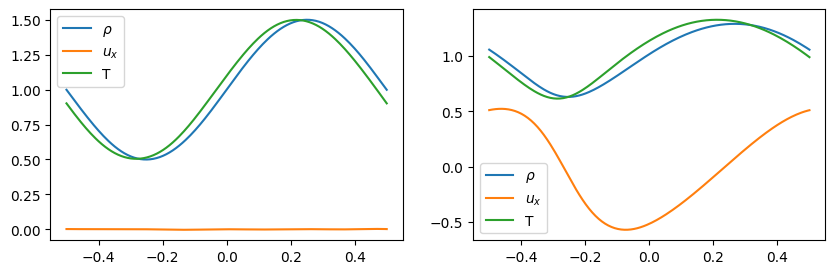

In [9]:
fig = visual(problem, config["visual_resolution"], "result.png")
fig.show()